In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from tqdm import tqdm_notebook

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel,
    NormalizingFlowModelWithCategorical
)
from nflib.utils import (plot_model, ConstrainedGaussian, DatasetMoons, WeirdConstrainedGaussian, 
                           DatasetSIGGRAPH, DatasetMixture, ConstrainedGaussianInner)
from nflib.spline_flows import NSF_AR, NSF_CL

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

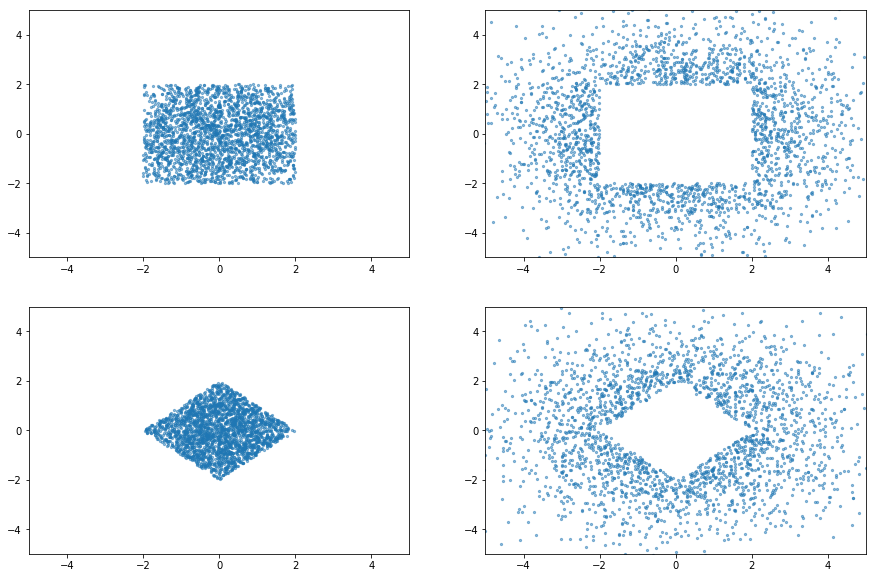

In [3]:
# Lightweight datasets
# d = ConstrainedGaussianInner()
# d = ConstrainedGaussian()
# d = DatasetMoons()
d = WeirdConstrainedGaussian()
# d = DatasetSIGGRAPH()
# d = DatasetMixture()
d.plot(10000)

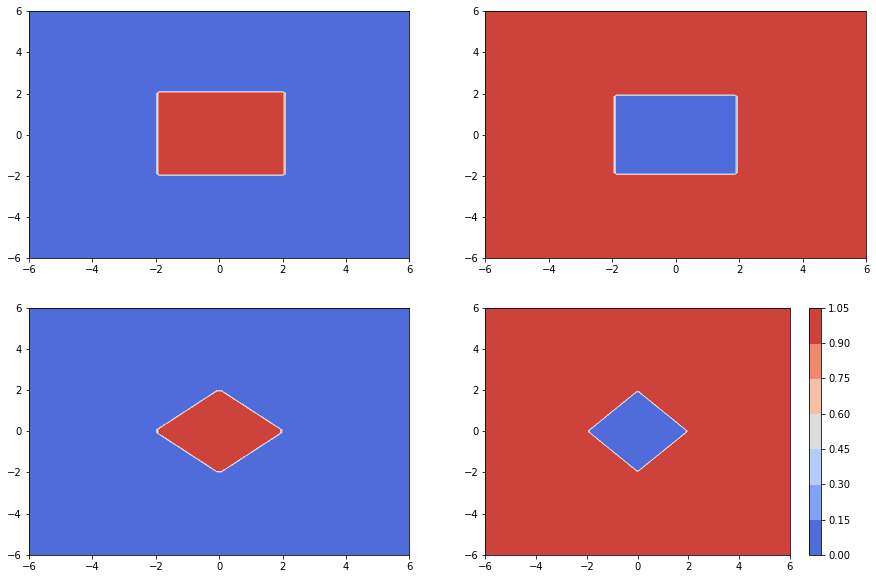

In [4]:
import scipy.stats as st

####### For 4 plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    xx, yy = np.mgrid[-6:6:100j, -6:6:100j]
    positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).float().T

    conts = torch.zeros((len(positions), 4)).float()
    conts[:, i] = 1

    ll = np.exp(d.eval_constraints(positions, conts))

    f = np.reshape(ll, xx.shape)

    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    cfset = ax.contourf(xx, yy, f, cmap='coolwarm')

####### For 1 plot
# fig, ax = plt.subplots(1,1, figsize=(8, 5))  
# xx, yy = np.mgrid[-6:6:100j, -6:6:100j]
# positions = torch.tensor(np.vstack([xx.ravel(), yy.ravel()])).float().T
# ll = np.exp(d.eval_constraints(positions, None))
# # ll = (d.eval_constraints(positions, None))
# f = np.reshape(ll, xx.shape)
# ax.set_xlim(-6, 6)
# ax.set_ylim(-6, 6)

cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
fig.colorbar(cfset, orientation='vertical')    
plt.show()

In [5]:
conditioning = True
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
flows = [AffineHalfFlow(dim=2, parity=i%2, 
                    conditioning=conditioning, num_conditioning=4) for i in range(5)]
mdl = NormalizingFlowModelWithCategorical(prior, flows, conditioning=conditioning, categorical_dims=4)

In [5]:
# construct a model
def build_model(num_layers=3, baseline=False):
    conditioning = True
    prior = MultivariateNormal(torch.zeros(2), torch.eye(2))
#     prior = TransformedDistribution(Uniform(torch.zeros(2), torch.ones(2)), 
#                             SigmoidTransform().inv) # Logistic distribution

    # RealNVP
    flows = [AffineHalfFlow(dim=2, parity=i%2, 
                    conditioning=conditioning, num_conditioning=4) for i in range(num_layers)]

# NICE
# flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(10)]
# flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(8)]

# MAF (with MADE net, so we get very fast density estimation)
# flows = [MAF(dim=2, parity=i%2) for i in range(10)]

# IAF (with MADE net, so we get very fast sampling)
# flows = [IAF(dim=2, parity=i%2) for i in range(3)]

# insert ActNorms to any of the flows above
# norms = [ActNorm(dim=2) for _ in flows]
# flows = list(itertools.chain(*zip(norms, flows)))

# Glow paper
# flows = [Invertible1x1Conv(dim=2) for i in range(3)]
# norms = [ActNorm(dim=2) for _ in flows]
# couplings = [AffineHalfFlow(dim=2, parity=i%2, nh=32) for i in range(len(flows))]
# flows = list(itertools.chain(*zip(norms, flows, couplings))) # append a coupling layer after each 1x1
#     else:
#         # Neural splines, coupling
#         nfs_flow = NSF_CL 
#         # nfs_flow = NSF_AR
#         flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
#         convs = [Invertible1x1Conv(dim=2) for _ in flows]
#         norms = [ActNorm(dim=2) for _ in flows]
#         flows = list(itertools.chain(*zip(norms, convs, flows)))

    return NormalizingFlowModelWithCategorical(prior, flows, conditioning=conditioning, categorical_dims=4)
#     return NormalizingFlowModel(prior, flows, conditioning=conditioning)
# construct the model

In [6]:
from torch.nn.utils import clip_grad_norm_

def train(model, d, optimizer, scheduler, back_kl=False, n_data=1000, 
          store_test=True, test_model=None, batch_size=128):
    
    cross_entropy = nn.CrossEntropyLoss()
    model.train()
    x_ = d.sample(n_data)
    
    x_test = d.sample(5000)

    train_statistics = []

    for k in tqdm_notebook(range(2000)):

        # forward KL
        x = x_[np.random.choice(range(n_data), size=batch_size)]
        zs, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss_fwd = -torch.sum(logprob) # NLL
        
        if back_kl:
            # backward KL
            num_sampls = np.min((k+1, 2*batch_size))
            xs, log_det = model.sample_backwards(num_sampls)
            
            categorical_variables = xs[:, :model.categorical_dims]
            continuous_variables = xs[:, model.categorical_dims:]
            
            unnorm_post_logprob = d.eval_constraints(continuous_variables, categorical_variables)
            loss_bkwd = -((unnorm_post_logprob.sum())+torch.sum(log_det[unnorm_post_logprob<0]))
        
            loss = loss_fwd + loss_bkwd
        else:
            loss = loss_fwd #+ loss_bkwd
            
            
        # add a categorical loss
        fwd_categorical = model.forward_categorical(x)
        _, targets = x[:,:model.categorical_dims].max(dim=1)
        categorical_loss = cross_entropy(fwd_categorical, targets)

        loss = loss + categorical_loss
        
        # do backprop
        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
#         if (k % 10 == 0) and store_test:
#             zs, prior_logprob, log_det = model(x_test[:,(-2,-1)], condition_variable=x_test[:,[0,1,2,3]]) 
#             loss_fwd_model = -torch.sum(prior_logprob + log_det)
            
#             z = model.prior.sample((5000,))
            
#             conditioning_variable = torch.zeros((5000, 4)).float()
#             var = np.random.choice(range(4), size=5000)
#             conditioning_variable[range(5000),var] = 1
            
#             xs, log_det = model.backward(z, condition_variable=conditioning_variable)
            
#             zs, prior_logprob, log_det = test_model(xs[-1], condition_variable=conditioning_variable)
#             loss_fwd = -torch.sum(prior_logprob + log_det)
            
#             train_statistics.append({
#                 'est_gen_loss': loss_fwd.item(),
#                 'est_loss_fwd': loss_fwd_model.item(),
#                 'broken_constraints': (~d.hard_constraint(xs[-1], conditioning_variable)).sum().item()
#             })

        if k % 100 == 1:
            print(loss_fwd.item(), loss.item())
    return train_statistics

In [7]:
def make_optimizer(model):
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3) # todo tune WD
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
    print("number of params: ", sum(p.numel() for p in model.parameters()))
    return optimizer, scheduler

In [8]:
# baseline = build_model(num_layers=15, baseline=True)
# optimizer, scheduler = make_optimizer(baseline)
# no_back_kl_stats = train(baseline, d, optimizer, scheduler, 
#                          back_kl=True, n_data=10000, store_test=False, batch_size=1000)

In [9]:
# baseline.eval()
# plot_model(d, baseline, constraint=to_plot[plot_idx], conditioning=True, index=plot_idx)

In [10]:
# construct the model
model_no_back_kl = build_model(baseline=False, num_layers=10)
optimizer, scheduler = make_optimizer(model_no_back_kl)
no_back_kl_stats = train(model_no_back_kl, d, optimizer, 
                         scheduler, back_kl=False, n_data=1000, test_model=None, batch_size=256)

number of params:  39384


665.652099609375 667.08056640625
457.728515625 459.16552734375
443.6346130371094 445.08380126953125
446.9128723144531 448.30389404296875
451.83990478515625 453.30712890625
433.29779052734375 434.70245361328125
460.6067810058594 462.0746765136719
453.0785217285156 454.5096130371094
426.4226379394531 427.8498229980469
442.1761474609375 443.6289367675781
442.18359375 443.62176513671875
445.96588134765625 447.42144775390625
402.1809997558594 403.6121520996094
419.6972961425781 421.1328430175781
413.1258239746094 414.58709716796875
425.3184814453125 426.7646179199219
415.29058837890625 416.7359924316406
405.5474853515625 406.9901428222656
412.236083984375 413.6831970214844
413.87060546875 415.2942810058594



In [14]:
model_plus_back_kl = build_model(baseline=False, num_layers=10)
optimizer, scheduler = make_optimizer(model_plus_back_kl)
plus_back_kl_stats = train(model_plus_back_kl, d, optimizer, 
                           scheduler, back_kl=True, n_data=1000, test_model=None, batch_size=256)

number of params:  39384


1198.064697265625 1204.4405517578125
942.8107299804688 962.16650390625
906.6129760742188 929.3425903320312
910.7225341796875 949.6192626953125
894.9666137695312 915.8359985351562
904.5247802734375 938.1259155273438
907.4161987304688 945.8408203125
892.2092895507812 935.9091796875
853.3544921875 879.3515625
882.5172729492188 918.3220825195312
908.4490966796875 949.413818359375
877.3372802734375 910.2081298828125
852.3380126953125 892.2525024414062
847.417724609375 893.62060546875
844.5587768554688 862.3279418945312
865.558837890625 896.73291015625
876.5743408203125 899.8466186523438
859.9205322265625 879.3021850585938
891.1295776367188 916.1836547851562
865.771728515625 883.8396606445312



In [18]:
model_no_back_kl.logits.grad

tensor([[ 3.7539e-05,  6.5159e-06, -2.4398e-05, -1.9657e-05]])

# generated: 15429
# broken constraint: 467
% broken constraint: 0.030267677749692138


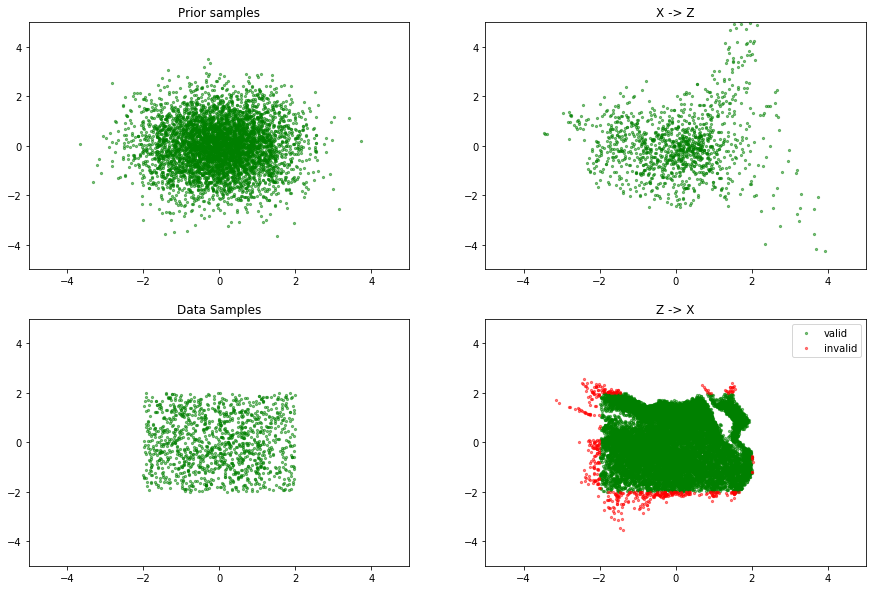

In [15]:
to_plot = [d.rest0, d.rest1, d.rest2, d.rest3]
plot_idx = 0

model_no_back_kl.eval()
# plot_model(d, model_no_back_kl, constraint=d.hard_constraint)
plot_model(d, model_no_back_kl, constraint=to_plot[plot_idx], conditioning=True, index=plot_idx)

# generated: 3069
# broken constraint: 153
% broken constraint: 0.04985337243401759


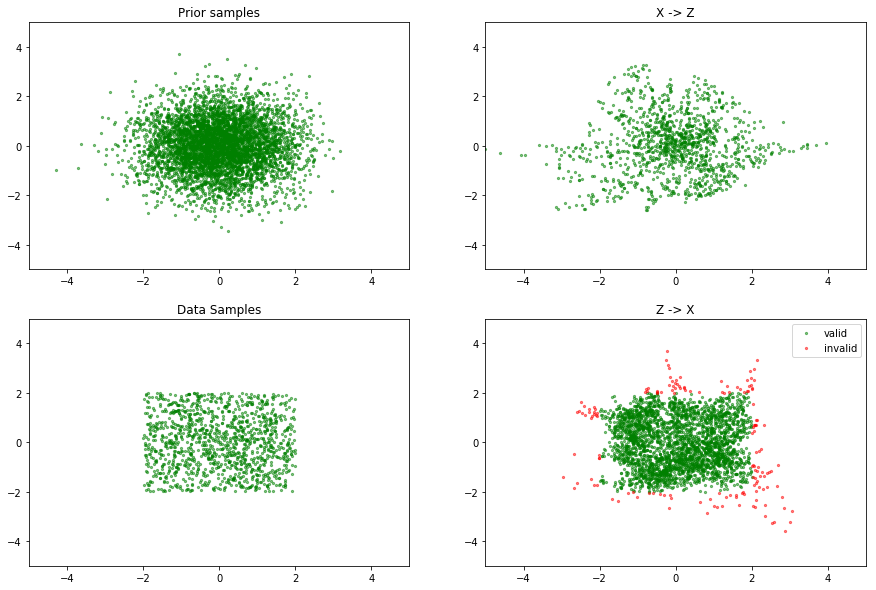

In [16]:
model_plus_back_kl.eval()
plot_model(d, model_plus_back_kl, constraint=to_plot[plot_idx], conditioning=True, index=plot_idx)

In [16]:
model_plus_back_kl.logits

Parameter containing:
tensor([[0.3427, 1.1350, 1.3756, 0.4594]], requires_grad=True)

In [63]:
df_1 = pd.DataFrame(no_back_kl_stats)
df_2 = pd.DataFrame(plus_back_kl_stats)

plt.figure(figsize=(10,4))
df_1.est_gen_loss.plot(label='W/O Constraints')
df_2.est_gen_loss.plot(label='W/ Constraints')
plt.legend(loc='best')
plt.title("-LL for both training scenarios")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'est_gen_loss'

<Figure size 720x288 with 0 Axes>

In [64]:
plt.figure(figsize=(10,4))
df_1.est_loss_fwd.plot(label='W/O Constraints')
df_2.est_loss_fwd.plot(label='W/ Constraints')
plt.legend(loc='best')
plt.title("-LL for both training scenarios")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'est_loss_fwd'

<Figure size 720x288 with 0 Axes>

In [65]:
plt.figure(figsize=(10,4))
df_1.broken_constraints.plot(label='W/O Constraints')
df_2.broken_constraints.plot(label='W/ Constraints')
plt.legend(loc='best')
plt.title("Number of broken constraints for both training scenarios")
plt.show()

AttributeError: 'DataFrame' object has no attribute 'broken_constraints'

<Figure size 720x288 with 0 Axes>

# Model the Entire Data Generating Process with Gumbel-Softmax on the Discrete Data

In [106]:
logits = torch.randn(5, 10)

# soft
print(F.gumbel_softmax(logits, tau=1, hard=False))

# hard
print(F.gumbel_softmax(logits, tau=1, hard=True))

tensor([[0.4172, 0.0061, 0.1252, 0.1395, 0.0151, 0.0096, 0.0056, 0.0303, 0.2104,
         0.0410],
        [0.0041, 0.0092, 0.0116, 0.0702, 0.0271, 0.0017, 0.8384, 0.0234, 0.0026,
         0.0116],
        [0.0630, 0.0155, 0.0348, 0.0368, 0.0230, 0.6317, 0.0274, 0.0379, 0.0879,
         0.0421],
        [0.0309, 0.0079, 0.2021, 0.0129, 0.0050, 0.0211, 0.5384, 0.1424, 0.0123,
         0.0270],
        [0.0506, 0.0252, 0.5345, 0.0267, 0.0109, 0.0739, 0.0111, 0.1555, 0.0719,
         0.0396]])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


In [107]:
class Example(nn.Module):
    def __init__(self):
        super().__init__()

        self.logits = nn.Parameter(torch.zeros((1,4)).normal_(), requires_grad=True)
        
    def forward(self, x):
        logits = self.logits.repeat(x.size()[0], 1)
        categorical_samples = F.gumbel_softmax(logits, tau=.5, hard=False, dim=-1)
        return categorical_samples
    
ex = Example()
op = optim.Adam(ex.parameters(), lr=1e-3) # todo tune WD

In [112]:
loss_fn = nn.NLLLoss()
for i in range(2500):
    samples = torch.tensor(np.random.choice(range(4), p=[.75,.2,.04,.01], size=128))
    
    input_ = ex.forward(samples)
    loss = loss_fn(torch.log(input_), samples).sum()
    
    ex.zero_grad()
    loss.backward()
    op.step()
    if i % 50 == 0:
        print(i, loss.item())

0 1.0246458053588867
50 0.8986060619354248
100 0.9382774233818054
150 1.1984304189682007
200 0.990034282207489
250 0.8896010518074036
300 0.9408118724822998
350 1.007519006729126
400 0.9648017883300781
450 0.9288769364356995
500 0.8804640769958496
550 0.9097488522529602
600 0.946875810623169
650 0.8505671620368958
700 1.1493102312088013
750 1.0983631610870361
800 0.895599901676178
850 1.0380939245224
900 1.0252774953842163
950 0.8673533201217651
1000 1.0257469415664673
1050 1.1055947542190552
1100 1.2161848545074463
1150 0.8094114065170288
1200 0.8523303270339966
1250 0.8604685068130493
1300 1.1176748275756836
1350 1.0436147451400757
1400 1.140679121017456
1450 0.8286595940589905
1500 0.9305816292762756
1550 0.9251164197921753
1600 1.057929515838623
1650 0.8877936601638794
1700 1.0512502193450928
1750 0.8008315563201904
1800 0.9124037027359009
1850 0.8402256965637207
1900 1.0978374481201172
1950 1.0341339111328125
2000 1.2307190895080566
2050 1.1073328256607056
2100 1.0652711391448975


In [114]:
torch.exp(ex.logits)/(torch.exp(ex.logits).sum())

tensor([[0.8629, 0.1190, 0.0137, 0.0043]], grad_fn=<DivBackward0>)

In [124]:
cat = torch.distributions.Categorical(probs=torch.ones(10)/10)
cat.log_prob(torch.tensor(4))

tensor(-2.3026)